### raw data
* word embedding: glove
* doc text: ./data/IMDB.txt

### dataset
1. IMDB
2. CNNNews
3. [PubMed](https://github.com/LIAAD/KeywordExtractor-Datasets/blob/master/datasets/PubMed.zip)

### preprocess
1. filter too frequent and less frequent words
2. stemming
3. document vector aggregation

### model
1. TopK
2. Sklearn
3. Our model

### evaluation
1. F1
2. NDCG

In [1]:
import os
from collections import defaultdict
import math
import numpy as np 
import re
import torch
import torch.nn as nn
from itertools import cycle
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from tqdm.auto import tqdm

# Used to get the data
from sklearn.metrics import ndcg_score

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
nltk.download('stopwords')

import matplotlib.pyplot as plt 
import pandas as pd

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chrisliu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocess config

In [2]:
config = {}

config["dataset"] = "PubMed" # "IMDB" "CNN", "PubMed"
config["n_document"] = 500
config["normalize_word_embedding"] = True
config["min_word_freq_threshold"] = 20
config["topk_word_freq_threshold"] = 300
config["document_vector_agg_weight"] = 'pmi' # ['mean', 'IDF', 'uniform', 'gaussian', 'exponential', 'pmi']
config["select_topk_TFIDF"] = None
config["embedding_file"] = "../data/glove.6B.100d.txt"


In [3]:
# load word embedding
embedding_file = config["embedding_file"]
word2embedding = dict()
word_dim = int(re.findall(r".(\d+)d",embedding_file)[0])

with open(embedding_file,"r") as f:
    for line in tqdm(f):
        line = line.strip().split()
        word = line[0]
        embedding = list(map(float,line[1:]))
        word2embedding[word] = np.array(embedding)

print("Number of words:%d" % len(word2embedding))

0it [00:00, ?it/s]

Number of words:400000


In [4]:
def normalize_wordemb(word2embedding):
    word_emb = []
    word_list = []
    for word, emb in word2embedding.items():
        word_list.append(word)
        word_emb.append(emb)

    word_emb = np.array(word_emb)

    for i in range(len(word_emb)):
        norm = np.linalg.norm(word_emb[i])
        word_emb[i] = word_emb[i] / norm

    for word, emb in tqdm(zip(word_list, word_emb)):
        word2embedding[word] = emb
    return word2embedding

if config["normalize_word_embedding"]:
    normalize_wordemb(word2embedding)

0it [00:00, ?it/s]

In [5]:
class Vocabulary:
    def __init__(self, word2embedding, min_word_freq_threshold=0, topk_word_freq_threshold=0):
        # The low frequency words will be assigned as <UNK> token
        self.itos = {0: "<UNK>"}
        self.stoi = {"<UNK>": 0}
        
        self.word2embedding = word2embedding
        self.min_word_freq_threshold = min_word_freq_threshold
        self.topk_word_freq_threshold = topk_word_freq_threshold
        
        self.word_freq_in_corpus = defaultdict(int)
        self.IDF = {}
        self.ps = PorterStemmer()
        self.stop_words = set(stopwords.words('english'))

    def __len__(self):
        return len(self.itos)

#     @staticmethod
    def tokenizer_eng(self, text):
        text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
        text = text.strip().split()
        
        return [self.ps.stem(w) for w in text if w.lower() not in self.stop_words]

    def build_vocabulary(self, sentence_list):
        self.doc_freq = defaultdict(int) # # of document a word appear
        self.document_num = len(sentence_list)
        self.word_vectors = [[0]*word_dim] # unknown word emb
        
        for sentence in tqdm(sentence_list, desc="Preprocessing documents"):
            # for doc_freq
            document_words = set()
            
            for word in self.tokenizer_eng(sentence):
                # pass unknown word
                if word not in self.word2embedding:
                    continue
                    
                # calculate word freq
                self.word_freq_in_corpus[word] += 1
                document_words.add(word)
                
            for word in document_words:
                self.doc_freq[word] += 1
        
        # calculate IDF
        print('doc num', self.document_num)
        for word, freq in self.doc_freq.items():
            self.IDF[word] = math.log(self.document_num / (freq+1))
        
        # delete less freq words:
        delete_words = []
        for word, v in self.word_freq_in_corpus.items():
            if v < self.min_word_freq_threshold:
                delete_words.append(word)     
        for word in delete_words:
            del self.IDF[word]    
            del self.word_freq_in_corpus[word]    
        
        # delete too freq words
        print('eliminate freq words')
        IDF = [(word, freq) for word, freq in self.IDF.items()]
        IDF.sort(key=lambda x: x[1])

        for i in range(self.topk_word_freq_threshold):
            print(word)
            word = IDF[i][0]
            del self.IDF[word]
            del self.word_freq_in_corpus[word]
        
        # construct word_vectors
        idx = 1
        for word in self.word_freq_in_corpus:
            self.word_vectors.append(self.word2embedding[word])
            self.stoi[word] = idx
            self.itos[idx] = word
            idx += 1
            
    def init_word_weight(self,sentence_list, agg):
        if agg == 'mean':
            self.word_weight = {word: 1 for word in self.IDF.keys()}
        elif agg == 'IDF':
            self.word_weight = self.IDF
        elif agg == 'uniform':
            self.word_weight = {word: np.random.uniform(low=0.0, high=1.0) for word in self.IDF.keys()}
        elif agg == 'gaussian':
            mu, sigma = 10, 1 # mean and standard deviation
            self.word_weight = {word: np.random.normal(mu, sigma) for word in self.IDF.keys()}
        elif agg == 'exponential':
            self.word_weight = {word: np.random.exponential(scale=1.0) for word in self.IDF.keys()}
        elif agg == 'pmi':
            trigram_measures = BigramAssocMeasures()
            self.word_weight = defaultdict(int)
            corpus = []

            for text in tqdm(sentence_list):
                corpus.extend(text.split())

            finder = BigramCollocationFinder.from_words(corpus)
            for pmi_score in finder.score_ngrams(trigram_measures.pmi):
                pair, score = pmi_score
                self.word_weight[pair[0]] += score
                self.word_weight[pair[1]] += score
                
    def calculate_document_vector(self, sentence_list, agg, n_document, select_topk_TFIDF=None):
        document_vectors = []
        document_answers = []
        document_answers_w = []
        
        self.init_word_weight(sentence_list, agg)
        
        for sentence in tqdm(sentence_list[:min(n_document, len(sentence_list))], desc="calculate document vectors"):
            document_vector = np.zeros(len(self.word_vectors[0]))
            select_words = []
            for word in self.tokenizer_eng(sentence):
                # pass unknown word
                if word not in self.stoi:
                    continue
                else:
                    select_words.append(word)

            # select topk TDIDF
            if select_topk_TFIDF is not None:
                doc_TFIDF = defaultdict(float)
                for word in select_words:    
                    doc_TFIDF[word] += self.IDF[word]

                doc_TFIDF_l = [(word, TFIDF) for word, TFIDF in doc_TFIDF.items()]
                doc_TFIDF_l.sort(key=lambda x:x[1], reverse=True)
                
                select_topk_words = set(list(map(lambda x:x[0], doc_TFIDF_l[:select_topk_TFIDF])))
                select_words = [word for word in select_words if word in select_topk_words]
            else:
                pass
            
            total_weight = 0
            # aggregate to doc vectors
            for word in select_words:
                document_vector += np.array(self.word2embedding[word]) * self.word_weight[word]
                total_weight += self.word_weight[word]
                
            if len(select_words) == 0:
                print('error', sentence)
                continue
            else:
                document_vector /= total_weight
            
            document_vectors.append(document_vector)
            document_answers.append(select_words)
            document_answers_w.append(total_weight)
        
        # get answers
        document_answers_idx = []    
        for ans in document_answers:
            ans_idx = []
            for token in ans:
                if token in self.stoi:
                    ans_idx.append(self.stoi[token])                    
            document_answers_idx.append(ans_idx)

        return document_vectors, document_answers_idx, document_answers_w
        
    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]

In [6]:
class CBowDataset(Dataset):
    def __init__(self, 
                 raw_data_file_path,
                 word2embedding,
                 skip_header = False,
                 n_document = None, # read first n document
                 min_word_freq_threshold = 20, # eliminate less freq words
                 topk_word_freq_threshold = 5, # eliminate smallest k IDF words
                 select_topk_TFIDF = None, # select topk tf-idf as ground-truth
                 document_vector_agg_weight = 'mean',
                 ):

        assert document_vector_agg_weight in ['mean', 'IDF', 'uniform', 'gaussian', 'exponential', 'pmi']
        
        # raw documents
        self.documents = []
        
        with open(raw_data_file_path,'r',encoding='utf-8') as f:
            if skip_header:
                f.readline()
            for line in tqdm(f, desc="Loading documents"):
                # read firt n document
                # if n_document is not None and len(self.documents) >= n_document:
                #     break    
                self.documents.append(line.strip("\n"))

        # build vocabulary
        self.vocab = Vocabulary(word2embedding, min_word_freq_threshold, topk_word_freq_threshold)
        self.vocab.build_vocabulary(self.documents)
        self.vocab_size = len(self.vocab)

        # calculate document vectors
        self.document_vectors, self.document_answers, self.document_answers_w = self.vocab.calculate_document_vector(self.documents, \
                                                                                           document_vector_agg_weight, n_document, select_topk_TFIDF)
                
        # train-test split
        # training
        self.train_split_ratio = 0.8
        self.train_length = int(len(self.document_answers) * self.train_split_ratio)
        self.train_vectors = self.document_vectors[:self.train_length]
        self.train_words = self.document_answers[:self.train_length]
        self.document_ids = list(range(self.train_length))
        self.generator = cycle(self.context_target_generator())
        self.dataset_size = sum([len(s) for s in self.train_words])
        
        # testing
        self.test_vectors = self.document_vectors[self.train_length:]
        self.test_words = self.document_answers[self.train_length:]

    def context_target_generator(self):
        np.random.shuffle(self.document_ids) # inplace shuffle

        # randomly select a document and create its training example
        for document_id in self.document_ids: 
            word_list = set(self.train_words[document_id])
            negative_sample_space = list(set(range(self.vocab_size)) - word_list)
            negative_samples = np.random.choice(negative_sample_space,size=len(word_list),replace = False)
            for word_id, negative_wordID in zip(word_list, negative_samples):
                yield [document_id, word_id, negative_wordID]
                
    def __getitem__(self, idx):
        doc_id, word_id, negative_wordID = next(self.generator)
        doc_id = torch.FloatTensor(self.document_vectors[doc_id])
        word_id = torch.FloatTensor(self.vocab.word_vectors[word_id])
        negative_word = torch.FloatTensor(self.vocab.word_vectors[negative_wordID])

        return doc_id, word_id, negative_word

    def __len__(self):
        return self.dataset_size 


In [7]:
# load and build torch dataset
if config["dataset"] == 'IMDB':
    data_file_path = '../data/IMDB.txt'
elif config["dataset"] == 'CNN':
    data_file_path = '../data/CNN.txt'
elif config["dataset"] == 'PubMed':
    data_file_path = '../data/PubMed.txt'

print("Building dataset....")
dataset = CBowDataset(
                    raw_data_file_path=data_file_path,
                    word2embedding=word2embedding,
                    skip_header=False,
                    n_document = config["n_document"],
                    min_word_freq_threshold = config["min_word_freq_threshold"],
                    topk_word_freq_threshold = config["topk_word_freq_threshold"],
                    document_vector_agg_weight = config["document_vector_agg_weight"],
                    select_topk_TFIDF = config["select_topk_TFIDF"]
                    )


Building dataset....


Loading documents: 0it [00:00, ?it/s]

Preprocessing documents:   0%|          | 0/495 [00:00<?, ?it/s]

doc num 495
eliminate freq words
tejada
use
studi
result
also
1
two
differ
2
one
data
may
includ
shown
present
show
3
follow
found
10
5
report
indic
4
three
perform
although
similar
suggest
respect
test
time
first
number
obtain
gener
method
could
level
control
sever
recent
detect
contain
well
previous
provid
activ
50
system
b
high
import
within
effect
posit
20
base
either
6
type
thu
fig
remain
cell
known
develop
h
standard
occur
like
100
consist
case
total
therefor
due
30
15
group
protein
higher
major
product
would
four
caus
confirm
condit
final
8
human
appear
express
c
less
whether
gene
assay
least
find
low
rel
7
function
accord
mani
complet
chang
among
second
support
contrast
small
rang
factor
valu
dna
collect
lower
select
form
without
process
site
region
acid
min
role
comparison
12
even
correspond
avail
reveal
25
per
new
rate
direct
allow
lead
limit
molecular
mean
treatment
affect
point
g
part
mm
sinc
design
five
set
lack
expect
complex
ident
combin
x
infect
model
carri
unit
ad
migh

  0%|          | 0/495 [00:00<?, ?it/s]

calculate document vectors:   0%|          | 0/495 [00:00<?, ?it/s]

In [8]:
print("Finish building dataset!")
print(f"Number of documents:{len(dataset.documents)}")
print(f"Number of words:{dataset.vocab_size}")

l = list(map(len, dataset.document_answers))
print("Average length of document:", np.mean(l))

Finish building dataset!
Number of documents:495
Number of words:3254
Average length of document: 827.020202020202


In [9]:
# check test doc vectors' correctness
word_vectors = np.array(dataset.vocab.word_vectors)
word_vectors.shape

pred = np.zeros(100)
cnt = 0
for word_idx in dataset.test_words[0]:
    pred += word_vectors[word_idx] * dataset.vocab.word_weight[dataset.vocab.itos[word_idx]]
    cnt += dataset.vocab.word_weight[dataset.vocab.itos[word_idx]]
print(dataset.test_vectors[0] - pred/cnt)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [10]:
## create weight_ans
document_answers = dataset.document_answers

onehot_ans = np.zeros((len(document_answers), word_vectors.shape[0]))
weight_ans = np.zeros((len(document_answers), word_vectors.shape[0]))
print(weight_ans.shape)

for i in tqdm(range(len(document_answers))):
    for word_idx in document_answers[i]:
        weight_ans[i, word_idx] += dataset.vocab.word_weight[dataset.vocab.itos[word_idx]]
        onehot_ans[i, word_idx] += 1

(495, 3254)


  0%|          | 0/495 [00:00<?, ?it/s]

In [11]:
document_vectors = np.array(dataset.document_vectors)
document_answers_w = np.array(dataset.document_answers_w).reshape(-1, 1)

## Results

In [12]:
final_results = []
select_columns = ['model', 'F1@50', 'F1@100', 'F1@200', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@all']

## setting training size

In [13]:
train_size_ratio = 1
train_size = int(len(dataset.document_answers) * train_size_ratio)
train_size

495

## Top K freq word

In [14]:
test_ans = dataset.document_answers[:train_size]

In [15]:
word_freq = [(word, freq) for word, freq in dataset.vocab.word_freq_in_corpus.items()]
word_freq.sort(key=lambda x:x[1], reverse=True)
word_freq[:10]

[('mutant', 3311),
 ('resist', 2604),
 ('rna', 2493),
 ('viru', 2386),
 ('transcript', 2121),
 ('plant', 1856),
 ('domain', 1834),
 ('mice', 1694),
 ('lane', 1638),
 ('plasmid', 1589)]

In [16]:
def topk_word_evaluation(k=50):
    topk_word = [word for (word, freq) in word_freq[:k]]

    pr, re = [], []
    for ans in tqdm(test_ans):
        ans = set(ans)
        ans = [dataset.vocab.itos[a] for a in ans]

        hit = []
        for word in ans:
            if word in topk_word:
                hit.append(word)

        precision = len(hit) / k
        recall = len(hit) / len(ans)
        pr.append(precision)
        re.append(recall)

    pr = np.mean(pr)
    re = np.mean(re)
    f1 = 2 * pr * re / (pr + re)
    print('top {} word'.format(k))
    print('percision', np.mean(pr))
    print('recall', np.mean(re))
    print('F1', f1)
    return f1

f1_50 = topk_word_evaluation(k=50)
f1_100 = topk_word_evaluation(k=100)
f1_200 = topk_word_evaluation(k=200)


  0%|          | 0/495 [00:00<?, ?it/s]

top 50 word
percision 0.26622222222222225
recall 0.05679479930912154
F1 0.09361759086910722


  0%|          | 0/495 [00:00<?, ?it/s]

top 100 word
percision 0.25103030303030305
recall 0.10869991523330824
F1 0.151707981565172


  0%|          | 0/495 [00:00<?, ?it/s]

top 200 word
percision 0.24075757575757575
recall 0.20613791256347172
F1 0.2221068030333533


In [17]:
def topk_word_evaluation_NDCG(k=50):
    freq_word =[word for (word, freq) in word_freq]
    freq_word_idx = [dataset.vocab.stoi[word] for word in freq_word if word in dataset.vocab.stoi]
    
    scores = np.zeros(len(dataset.vocab.word_vectors))
    for rank, idx in enumerate(freq_word_idx):
        scores[idx] = len(dataset.vocab.word_vectors) - rank
    
    NDCGs = []
    
    for ans in tqdm(test_ans):
        weight_ans = np.zeros(len(dataset.vocab.word_vectors))
        
        for word_idx in ans:
            if word_idx == 0:
                continue
            word = dataset.vocab.itos[word_idx]
            weight_ans[word_idx] += dataset.vocab.IDF[word]

        NDCG_score = ndcg_score(weight_ans.reshape(1,-1), scores.reshape(1,-1), k=k)
        NDCGs.append(NDCG_score)

    print('top {} NDCG:{}'.format(k, np.mean(NDCGs)))
    
    return np.mean(NDCGs)

ndcg_50 = topk_word_evaluation_NDCG(k=50)
ndcg_100 = topk_word_evaluation_NDCG(k=100)
ndcg_200 = topk_word_evaluation_NDCG(k=200)
ndcg_all = topk_word_evaluation_NDCG(k=None)


  0%|          | 0/495 [00:00<?, ?it/s]

top 50 NDCG:0.07563302439890733


  0%|          | 0/495 [00:00<?, ?it/s]

top 100 NDCG:0.09269527180595286


  0%|          | 0/495 [00:00<?, ?it/s]

top 200 NDCG:0.1170920989055331


  0%|          | 0/495 [00:00<?, ?it/s]

top None NDCG:0.3332565846897621


In [18]:
topk_results =  {"model": "topk",
               "F1@50": f1_50, 
               "F1@100": f1_100, 
               "F1@200": f1_200, 
               "ndcg@50": ndcg_50, 
               "ndcg@100": ndcg_100, 
               "ndcg@200": ndcg_200, 
               "ndcg@all": ndcg_all}
final_results.append(pd.Series(topk_results))

## Sklearn

In [19]:
from sklearn.linear_model import LinearRegression, Lasso

In [20]:
print(document_vectors.shape)
print(weight_ans.shape)
print(word_vectors.shape)

(495, 100)
(495, 3254)
(3254, 100)


In [21]:
def evaluate_sklearn(pred, ans):
    results = {}
        
    one_hot_ans = np.arange(ans.shape[0])[ans > 0]
    
    for topk in [50, 100, 200]:
        one_hot_pred = np.argsort(pred)[-topk:]
        hit = np.intersect1d(one_hot_pred, one_hot_ans)
        percision = len(hit) / topk
        recall = len(hit) / len(one_hot_ans)
        
        results['F1@{}'.format(topk)] = 2 * percision * recall / (percision + recall)
        
    ans = ans.reshape(1, -1)
    pred = pred.reshape(1, -1)
    results['ndcg@50'] = (ndcg_score(ans, pred, k=50))
    results['ndcg@100'] = (ndcg_score(ans, pred, k=100))
    results['ndcg@200'] = (ndcg_score(ans, pred, k=200))
    results['ndcg@all'] = (ndcg_score(ans, pred, k=None))
    
    return results

### linear regression

In [22]:
results = []

for doc_id, doc_emb in enumerate(tqdm(document_vectors[:train_size])):
    x = word_vectors.T
    y = doc_emb
    
    ans = weight_ans[doc_id]
    model = LinearRegression(fit_intercept=False).fit(x, y)
    r2 = model.score(x, y)

    res = evaluate_sklearn(model.coef_, ans)
    results.append(res)

  0%|          | 0/495 [00:00<?, ?it/s]

In [23]:
results = pd.DataFrame(results).mean()
results['model'] = 'sk-linear-regression'
final_results.append(results)
results

F1@50                   0.117154
F1@100                  0.148277
F1@200                    0.1725
ndcg@50                 0.673415
ndcg@100                0.671709
ndcg@200                0.686655
ndcg@all                0.788487
model       sk-linear-regression
dtype: object

In [24]:
results = []

for doc_id, doc_emb in enumerate(tqdm(document_vectors[:train_size])):
    x = word_vectors.T
    y = doc_emb
    
    ans = weight_ans[doc_id]
    model = Lasso(positive=True, fit_intercept=False, alpha=0.0001, max_iter=10000, tol=0).fit(x, y)
    r2 = model.score(x, y)

    res = evaluate_sklearn(model.coef_, ans)
    results.append(res)

  0%|          | 0/495 [00:00<?, ?it/s]

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.710505431213761e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6020852139652106e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0083080204115191e-16, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to incr

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1384122811097797e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1427490897997217e-16, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.905661822261152e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to incr

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.452830911130576e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.7921736023859296e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2985086056692694e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to incr

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6263032587282567e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.924811864397526e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.456776945386935e-18, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to incre

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.204170427930421e-18, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.734723475976807e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3259666682171627e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to incre

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.61039323437673e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.117434254131581e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5804011705155006e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increa

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0408340855860843e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.440160904563896e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.380882793312949e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to incre

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.119968255444917e-18, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3986208025063007e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.69712940817557e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increa

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.053088140253962e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1008182133085427e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.155028321932818e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to incre

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6696713456276768e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.589415207398531e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.787105599759258e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to incre

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3227266504323154e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.870601755773251e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.553649124439119e-18, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to incre

/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3444106938820255e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3769367590565906e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2902005852577503e-17, tolerance: 0.0
  positive)
/home/chrisliu/virtual_env/py37/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to inc

In [25]:
results = pd.DataFrame(results).mean()
results['model'] = 'sk-lasso'
final_results.append(results)
results

F1@50       0.194806
F1@100      0.205829
F1@200      0.188654
ndcg@50     0.806047
ndcg@100    0.787418
ndcg@200    0.778638
ndcg@all    0.864406
model       sk-lasso
dtype: object

## Our Model

In [26]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [27]:
class Custom_Dataset(Dataset):
    def __init__(self, 
                 doc_vectors,
                 doc_w_sum,
                 weight_ans
                 ):
        self.doc_vectors = torch.FloatTensor(doc_vectors)
        self.doc_w_sum = torch.FloatTensor(doc_w_sum)
        self.weight_ans = weight_ans
        assert len(doc_vectors) == len(doc_w_sum)
        
    def __getitem__(self, idx):
                
        return self.doc_vectors[idx], self.doc_w_sum[idx], idx

    def __len__(self):
        return len(self.doc_vectors)


In [28]:
class LR(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, num_doc, num_words):
        super(LR, self).__init__()
        weight = torch.zeros(num_doc, num_words).to(device)
        self.emb = torch.nn.Embedding.from_pretrained(weight, freeze=False)
        
    def forward(self, doc_ids, word_vectors):
        return self.emb(doc_ids) @ word_vectors

In [29]:
def evaluate_NDCG(model, train_loader):
    results = {}
    model.eval()
    
    scores = np.array(model.emb.cpu().weight.data)
    model.emb.to(device)
    true_relevance = train_loader.dataset.weight_ans

    # F1
    F1s = []
    for i in range(true_relevance.shape[0]):
        one_hot_ans = np.arange(true_relevance.shape[1])[true_relevance[i] > 0]
        pred = scores[i]
        
        F1 = []
        for topk in [50, 100, 200]:
            one_hot_pred = np.argsort(pred)[-topk:]
            
            hit = np.intersect1d(one_hot_pred, one_hot_ans)
            percision = len(hit) / topk
            recall = len(hit) / len(one_hot_ans)
            
            ans = 2 * percision * recall / (percision + recall) if (percision + recall) > 0 else 0
            F1.append(ans)
        F1s.append(F1)
        
    F1s = np.mean(F1s, axis=0)
    results['F1@50'] = F1s[0]
    results['F1@100'] = F1s[1]
    results['F1@200'] = F1s[2]

    # NDCG
    results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
    results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
    results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
    results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))
    
    return results

In [30]:
batch_size = 100
print('document num', train_size)

train_dataset = Custom_Dataset(document_vectors[:train_size], document_answers_w[:train_size], weight_ans[:train_size])
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

document num 495


## start training

In [31]:
# setting
lr = 0.5
momentum = 0.99
weight_decay = 0
nesterov = False # True

n_epoch = 50000

w_sum_reg = 1e-3
w_sum_reg_mul = 0.9
w_clip_value = 0

L1 = 1e-6

verbose = True
valid_epoch = 100

model = LR(num_doc=train_size, num_words=word_vectors.shape[0]).to(device)
model.train()

word_vectors_tensor = torch.FloatTensor(word_vectors).to(device)
    
opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=nesterov)
criterion = nn.MSELoss(reduction='mean')

results = []
step = 0
for epoch in tqdm(range(n_epoch)):    
    loss_mse_his = []
    loss_w_reg_his = []
    
    model.train()

    for data in train_loader:
        doc_embs, doc_w_sum, doc_ids = data
        
        doc_embs = doc_embs.to(device)
        doc_w_sum = doc_w_sum.to(device)
        doc_ids = doc_ids.to(device)
        
        w_reg = (torch.ones(doc_embs.size(0), 1) * w_sum_reg_mul).to(device)
        
        # MSE loss
        pred_doc_embs = model(doc_ids, word_vectors_tensor)     
        loss_mse = criterion(pred_doc_embs, doc_embs)

        pred_w_sum = torch.sum(model.emb(doc_ids), axis=1).view(-1, 1)
        loss_w_reg = criterion(pred_w_sum, w_reg)
        
        loss_l1 = torch.sum(torch.abs(model.emb(doc_ids)))
        loss = loss_mse + loss_w_reg * w_sum_reg + loss_l1 * L1
        
        # Model backwarding
        model.zero_grad()
        loss.backward()
        opt.step()

        loss_mse_his.append(loss_mse.item())
        loss_w_reg_his.append(loss_w_reg.item())

        for p in model.parameters():
            p.data.clamp_(w_clip_value, float('inf'))

        
    if epoch % valid_epoch == 0:
        res = {}
        res['epoch'] = epoch
        res['loss_mse'] = np.mean(loss_mse_his)
        res['loss_w_reg'] = np.mean(loss_w_reg_his)
        
        res_ndcg = evaluate_NDCG(model, train_loader)
        res.update(res_ndcg)
        results.append(res)
        
        print()
        if verbose:
            for k, v in res.items():
                print(k, v)

  0%|          | 0/50000 [00:00<?, ?it/s]


epoch 0
loss_mse 0.0026875839103013277
loss_w_reg 0.8099999070167542
F1@50 0.11950059005762347
F1@100 0.1684528889382753
F1@200 0.21384006517181312
ndcg@50 0.4141424446259516
ndcg@100 0.4316706372373855
ndcg@200 0.46145986876161116
ndcg@all 0.5893828851984236

epoch 100
loss_mse 3.7533824797719714e-05
loss_w_reg 0.009740154445171356
F1@50 0.14107103044023242
F1@100 0.18089334872318977
F1@200 0.2141224258537623
ndcg@50 0.7295829405796692
ndcg@100 0.727021956892266
ndcg@200 0.7434293991640193
ndcg@all 0.8291294452062347

epoch 200
loss_mse 2.1782025942229666e-05
loss_w_reg 0.0053569312207400795
F1@50 0.149002577205651
F1@100 0.18957007804020967
F1@200 0.2225586733479815
ndcg@50 0.7469110320157494
ndcg@100 0.7434296103190928
ndcg@200 0.7600305874440904
ndcg@all 0.8416783967483451

epoch 300
loss_mse 1.5267985327227505e-05
loss_w_reg 0.003480930859223008
F1@50 0.15404819838428704
F1@100 0.19426945588563185
F1@200 0.22747575767710546
ndcg@50 0.7565964071953603
ndcg@100 0.7531128164257608
n


epoch 3100
loss_mse 1.686357359176327e-06
loss_w_reg 0.0004278275358956307
F1@50 0.1941288379430959
F1@100 0.23556062568058556
F1@200 0.25989796895338324
ndcg@50 0.8166225769636194
ndcg@100 0.8102959584876913
ndcg@200 0.822213168849154
ndcg@all 0.8903584544981423

epoch 3200
loss_mse 1.6547579662073986e-06
loss_w_reg 0.00043297982192598284
F1@50 0.1948129144357629
F1@100 0.2360932882722761
F1@200 0.2592275319505035
ndcg@50 0.8173604779032486
ndcg@100 0.8109439339776726
ndcg@200 0.8223146720500253
ndcg@all 0.8906212482902066

epoch 3300
loss_mse 1.6267408227577107e-06
loss_w_reg 0.000437107915058732
F1@50 0.19504456220680777
F1@100 0.23610908872490027
F1@200 0.2601291371624621
ndcg@50 0.8179685422612029
ndcg@100 0.8114086355262109
ndcg@200 0.822857456061084
ndcg@all 0.891206860622935

epoch 3400
loss_mse 1.6012621472327738e-06
loss_w_reg 0.00044223058503121135
F1@50 0.19536132595725905
F1@100 0.23690205142669743
F1@200 0.25965266560189604
ndcg@50 0.8184561356459533
ndcg@100 0.812050194


epoch 6200
loss_mse 1.2825057183363242e-06
loss_w_reg 0.0005362113355658948
F1@50 0.20197755465969794
F1@100 0.24255160979050705
F1@200 0.26363459254076116
ndcg@50 0.8274969755249146
ndcg@100 0.8199254629687331
ndcg@200 0.8298649057424671
ndcg@all 0.8970110430885818

epoch 6300
loss_mse 1.278419335903891e-06
loss_w_reg 0.0005375837441533804
F1@50 0.20186962592369306
F1@100 0.24234456113913933
F1@200 0.26270204942556485
ndcg@50 0.8276757462011802
ndcg@100 0.8200061468474076
ndcg@200 0.8301095263349391
ndcg@all 0.8970248259382092

epoch 6400
loss_mse 1.272863391932333e-06
loss_w_reg 0.0005390101694501936
F1@50 0.20172826418908066
F1@100 0.24233097227916375
F1@200 0.2628964005547562
ndcg@50 0.827808345269474
ndcg@100 0.8202075614152354
ndcg@200 0.8301032286326141
ndcg@all 0.8972579273503177

epoch 6500
loss_mse 1.2689882169070188e-06
loss_w_reg 0.0005414146929979324
F1@50 0.20182697824087922
F1@100 0.24224998463791006
F1@200 0.263238175760936
ndcg@50 0.8279933350592528
ndcg@100 0.8202706


epoch 9300
loss_mse 1.200098404297023e-06
loss_w_reg 0.0005797791294753551
F1@50 0.20405763621106923
F1@100 0.2424784753764733
F1@200 0.2631424925247887
ndcg@50 0.8308078226446269
ndcg@100 0.8218095070864675
ndcg@200 0.8317101007330449
ndcg@all 0.8987890988449796

epoch 9400
loss_mse 1.1979495411651441e-06
loss_w_reg 0.0005809387192130088
F1@50 0.20410611753181546
F1@100 0.24258821550747187
F1@200 0.2627483129974369
ndcg@50 0.8308968086875351
ndcg@100 0.82191283711685
ndcg@200 0.8317649468487295
ndcg@all 0.8987912826150629

epoch 9500
loss_mse 1.1963958968408405e-06
loss_w_reg 0.0005823567160405218
F1@50 0.20425322128595583
F1@100 0.2423095064619142
F1@200 0.2633111139769099
ndcg@50 0.8309956652278981
ndcg@100 0.8220082438137639
ndcg@200 0.8322193805190652
ndcg@all 0.898835237328044

epoch 9600
loss_mse 1.194567653328704e-06
loss_w_reg 0.0005841912585310638
F1@50 0.20432476069336256
F1@100 0.24262500760321168
F1@200 0.26355189995407724
ndcg@50 0.8310165090550083
ndcg@100 0.82217298060


epoch 12400
loss_mse 1.1704738881235243e-06
loss_w_reg 0.000603877758840099
F1@50 0.20458718580908755
F1@100 0.24294922532354893
F1@200 0.2640327874062028
ndcg@50 0.8316305974538888
ndcg@100 0.8231228119289113
ndcg@200 0.8327917772322048
ndcg@all 0.8995573521620329

epoch 12500
loss_mse 1.1702011533998301e-06
loss_w_reg 0.0006016839935909957
F1@50 0.20468632224976807
F1@100 0.24358733489735063
F1@200 0.263662135462933
ndcg@50 0.831631801131774
ndcg@100 0.8230978027172987
ndcg@200 0.8326157342561761
ndcg@all 0.8994561676328355

epoch 12600
loss_mse 1.1694027307385112e-06
loss_w_reg 0.0006037476123310626
F1@50 0.20463884692164427
F1@100 0.2430216987116332
F1@200 0.26347818079699786
ndcg@50 0.8316417392164571
ndcg@100 0.8230556944679822
ndcg@200 0.8323428235127504
ndcg@all 0.8993858335140941

epoch 12700
loss_mse 1.1696194860633114e-06
loss_w_reg 0.0006051302189007401
F1@50 0.20467506088922505
F1@100 0.24285994266066285
F1@200 0.26424851149190093
ndcg@50 0.8316940779801458
ndcg@100 0.822


epoch 15500
loss_mse 1.1587091876208434e-06
loss_w_reg 0.0006145403138361871
F1@50 0.20504577991475367
F1@100 0.2430402942013517
F1@200 0.2638902706930446
ndcg@50 0.8321806073452869
ndcg@100 0.8234361080935997
ndcg@200 0.8328948450821992
ndcg@all 0.8997047805647898

epoch 15600
loss_mse 1.1581787020986666e-06
loss_w_reg 0.0006150425993837416
F1@50 0.20512927977614479
F1@100 0.24313776530722472
F1@200 0.2632457454191427
ndcg@50 0.832259749624871
ndcg@100 0.823495637757797
ndcg@200 0.833002453624329
ndcg@all 0.8997106898127756

epoch 15700
loss_mse 1.158043664872821e-06
loss_w_reg 0.0006155490875244141
F1@50 0.20512285237525457
F1@100 0.24336909083460154
F1@200 0.26358585453034106
ndcg@50 0.8322545983127981
ndcg@100 0.823434613144848
ndcg@200 0.8327103129470571
ndcg@all 0.8996716985707304

epoch 15800
loss_mse 1.156475263996981e-06
loss_w_reg 0.0006154965725727379
F1@50 0.20514124692295127
F1@100 0.24277090163956005
F1@200 0.2629478675831906
ndcg@50 0.8322442044484119
ndcg@100 0.8232408


epoch 18600
loss_mse 1.1502623010528622e-06
loss_w_reg 0.0006215010769665241
F1@50 0.20519965597997075
F1@100 0.2428601719325492
F1@200 0.26334673124340924
ndcg@50 0.8324353112022416
ndcg@100 0.8235437119534
ndcg@200 0.8331150056805434
ndcg@all 0.8998286735100898

epoch 18700
loss_mse 1.1500134633024573e-06
loss_w_reg 0.0006202263408340514
F1@50 0.20509622760888413
F1@100 0.24338706836750285
F1@200 0.26349034189058884
ndcg@50 0.8324035805607252
ndcg@100 0.8235384072757491
ndcg@200 0.8329069608721742
ndcg@all 0.8996590588090002

epoch 18800
loss_mse 1.1495770877445466e-06
loss_w_reg 0.0006233263178728521
F1@50 0.20524220561206383
F1@100 0.24297171766877007
F1@200 0.2631401837711814
ndcg@50 0.8324643668540959
ndcg@100 0.8235768885671754
ndcg@200 0.8326689427448895
ndcg@all 0.8999101059066908

epoch 18900
loss_mse 1.1508416264405241e-06
loss_w_reg 0.0006217530579306185
F1@50 0.20514838369921798
F1@100 0.24343361557899476
F1@200 0.2636179372203364
ndcg@50 0.8324189497074213
ndcg@100 0.823


epoch 21700
loss_mse 1.1460848782007814e-06
loss_w_reg 0.0006259753019548953
F1@50 0.20510549238976603
F1@100 0.24306985128960998
F1@200 0.2637819382760894
ndcg@50 0.8322669814027279
ndcg@100 0.8234916001273703
ndcg@200 0.8327366377204888
ndcg@all 0.899563233275868

epoch 21800
loss_mse 1.1463879218354124e-06
loss_w_reg 0.0006268301280215382
F1@50 0.20508177517023674
F1@100 0.24350469277438738
F1@200 0.26375810804006145
ndcg@50 0.8322500661626254
ndcg@100 0.8234510380450586
ndcg@200 0.8327136841431507
ndcg@all 0.8997329063738929

epoch 21900
loss_mse 1.147149669122882e-06
loss_w_reg 0.0006285938085056842
F1@50 0.20510922671549334
F1@100 0.2434425455863266
F1@200 0.2632205855236179
ndcg@50 0.8322248524077259
ndcg@100 0.8235759194595073
ndcg@200 0.832489338991972
ndcg@all 0.899686747679169

epoch 22000
loss_mse 1.1450700185378083e-06
loss_w_reg 0.0006275927415117621
F1@50 0.20502361531727273
F1@100 0.2431921087905014
F1@200 0.2635327898235169
ndcg@50 0.8321704895302197
ndcg@100 0.823573


epoch 24800
loss_mse 1.1443349649198354e-06
loss_w_reg 0.0006306770374067128
F1@50 0.20485004145467908
F1@100 0.24314790677971918
F1@200 0.2633058791927155
ndcg@50 0.8323153025805365
ndcg@100 0.8236296885758965
ndcg@200 0.8328073392159959
ndcg@all 0.8998456321347847

epoch 24900
loss_mse 1.1436316981416895e-06
loss_w_reg 0.0006296644220128656
F1@50 0.20480211332594286
F1@100 0.2424389223101674
F1@200 0.2622240905175882
ndcg@50 0.8323180277230433
ndcg@100 0.8234210167763918
ndcg@200 0.8323205517851974
ndcg@all 0.8996748005081168

epoch 25000
loss_mse 1.1432630117269583e-06
loss_w_reg 0.0006319264066405594
F1@50 0.20479162149038094
F1@100 0.24344502821213493
F1@200 0.26405087454261117
ndcg@50 0.8323310929132456
ndcg@100 0.823548210656878
ndcg@200 0.8324657909101222
ndcg@all 0.8997581886405973

epoch 25100
loss_mse 1.1439282388892024e-06
loss_w_reg 0.0006322731613181531
F1@50 0.20486810804960562
F1@100 0.24285438190681286
F1@200 0.2635868158546525
ndcg@50 0.8323693380533322
ndcg@100 0.82


epoch 27900
loss_mse 1.1417411542424816e-06
loss_w_reg 0.0006315151113085449
F1@50 0.2051329460818683
F1@100 0.2430256909648371
F1@200 0.2629336014640292
ndcg@50 0.8324848222482012
ndcg@100 0.823731338739611
ndcg@200 0.8328765578630829
ndcg@all 0.8998037167949772

epoch 28000
loss_mse 1.1414282198529691e-06
loss_w_reg 0.0006343606510199606
F1@50 0.2051190618564735
F1@100 0.2436402659659814
F1@200 0.26429439406380023
ndcg@50 0.8324788485917599
ndcg@100 0.8237066501478796
ndcg@200 0.8331096182321496
ndcg@all 0.8999340915074959

epoch 28100
loss_mse 1.1422862144172542e-06
loss_w_reg 0.0006338584236800671
F1@50 0.2051833889827716
F1@100 0.2430059510583595
F1@200 0.26393342535007835
ndcg@50 0.8325093522992002
ndcg@100 0.823663183450583
ndcg@200 0.8327784013813809
ndcg@all 0.8998368863877629

epoch 28200
loss_mse 1.1413875199650648e-06
loss_w_reg 0.0006319153122603893
F1@50 0.20518450152708176
F1@100 0.24305696384589204
F1@200 0.2639609899855036
ndcg@50 0.8324820618188622
ndcg@100 0.8234836


epoch 31000
loss_mse 1.1404066754039376e-06
loss_w_reg 0.0006352941156364978
F1@50 0.2050062661755338
F1@100 0.24333361585698832
F1@200 0.26284355333271237
ndcg@50 0.8324869361561568
ndcg@100 0.8238059814006438
ndcg@200 0.8327197119615459
ndcg@all 0.8997324636618045

epoch 31100
loss_mse 1.14143645078002e-06
loss_w_reg 0.0006326712551526726
F1@50 0.20499413108422762
F1@100 0.24283064294900952
F1@200 0.26296317650964046
ndcg@50 0.8324975099662378
ndcg@100 0.8235084052898061
ndcg@200 0.8327459648798397
ndcg@all 0.8996658238104266

epoch 31200
loss_mse 1.1400753692214494e-06
loss_w_reg 0.0006350101088173687
F1@50 0.20499413108422762
F1@100 0.2427592777020459
F1@200 0.263285127829902
ndcg@50 0.8325048818616264
ndcg@100 0.8235050575232772
ndcg@200 0.83308123939129
ndcg@all 0.8997820691951165

epoch 31300
loss_mse 1.1414117352614995e-06
loss_w_reg 0.0006351054878905415
F1@50 0.20497916662481871
F1@100 0.24377658155433457
F1@200 0.26374137986703844
ndcg@50 0.8324959570498789
ndcg@100 0.82364


epoch 34100
loss_mse 1.1395464980523684e-06
loss_w_reg 0.0006361693958751857
F1@50 0.2049435912965327
F1@100 0.24333057309462186
F1@200 0.2639343434975399
ndcg@50 0.8324060320248362
ndcg@100 0.8236473090095637
ndcg@200 0.8325726415752115
ndcg@all 0.8995962186551802

epoch 34200
loss_mse 1.1397252137612668e-06
loss_w_reg 0.0006374370539560914
F1@50 0.20497559346669333
F1@100 0.24306572707065374
F1@200 0.26336569003256555
ndcg@50 0.8324516252180997
ndcg@100 0.8234797043337266
ndcg@200 0.8324525761546997
ndcg@all 0.8996767128719707

epoch 34300
loss_mse 1.1388861821615138e-06
loss_w_reg 0.0006377010839059948
F1@50 0.20495245536375986
F1@100 0.2430724065200455
F1@200 0.26382902664762803
ndcg@50 0.8324388349557371
ndcg@100 0.8234034269586054
ndcg@200 0.8325877684492536
ndcg@all 0.8996486482118801

epoch 34400
loss_mse 1.1393829481676221e-06
loss_w_reg 0.0006377513869665563
F1@50 0.20498083143481652
F1@100 0.24392615011730517
F1@200 0.26356327660918283
ndcg@50 0.8324409382878093
ndcg@100 0.


epoch 37200
loss_mse 1.1379572242731228e-06
loss_w_reg 0.0006394853931851685
F1@50 0.20515046742724152
F1@100 0.2428841546571735
F1@200 0.2630052017628964
ndcg@50 0.8327536589140767
ndcg@100 0.8235410866682822
ndcg@200 0.8328056748865958
ndcg@all 0.8997482608416849

epoch 37300
loss_mse 1.138969446401461e-06
loss_w_reg 0.0006386824417859316
F1@50 0.20511581960218966
F1@100 0.24290315941284246
F1@200 0.26306276750420476
ndcg@50 0.832725014196867
ndcg@100 0.8235167765895902
ndcg@200 0.8325959040481941
ndcg@all 0.8996667806827213

epoch 37400
loss_mse 1.1402904419810512e-06
loss_w_reg 0.0006377364159561693
F1@50 0.2051604513330529
F1@100 0.24309704146615013
F1@200 0.2631900415826168
ndcg@50 0.8327246712869544
ndcg@100 0.8236059066797459
ndcg@200 0.8329100378767561
ndcg@all 0.8996082054653686

epoch 37500
loss_mse 1.1389176279408276e-06
loss_w_reg 0.0006401120102964341
F1@50 0.20518936258325124
F1@100 0.24244635222631924
F1@200 0.2630449468062626
ndcg@50 0.8327266222744287
ndcg@100 0.8234


epoch 40300
loss_mse 1.1385820471332408e-06
loss_w_reg 0.0006392828770913183
F1@50 0.2052448426229266
F1@100 0.24279366079847906
F1@200 0.26349961963486485
ndcg@50 0.8328314592796933
ndcg@100 0.8235749143982086
ndcg@200 0.8327885164327946
ndcg@all 0.8995997457483366

epoch 40400
loss_mse 1.1397407433832995e-06
loss_w_reg 0.0006369535811245441
F1@50 0.2052594390779107
F1@100 0.24301763376486685
F1@200 0.2632653997137009
ndcg@50 0.8328329274328917
ndcg@100 0.8236011305751278
ndcg@200 0.8327226869975304
ndcg@all 0.8996985195156564

epoch 40500
loss_mse 1.1380859859855263e-06
loss_w_reg 0.0006396157434210182
F1@50 0.20523314013609148
F1@100 0.24242695483152918
F1@200 0.26240467646670257
ndcg@50 0.832832294759208
ndcg@100 0.8232816574660514
ndcg@200 0.8323039998846439
ndcg@all 0.8994848034881988

epoch 40600
loss_mse 1.1381046078895452e-06
loss_w_reg 0.0006401997175998986
F1@50 0.2052454584410927
F1@100 0.2427371523888915
F1@200 0.26350484496823795
ndcg@50 0.8328325867436848
ndcg@100 0.823


epoch 43400
loss_mse 1.1385447578504681e-06
loss_w_reg 0.0006400239886716008
F1@50 0.20524654414477214
F1@100 0.24328746276362254
F1@200 0.2634991783151543
ndcg@50 0.8328109864312246
ndcg@100 0.8235309770660895
ndcg@200 0.832522082948611
ndcg@all 0.899571255361008

epoch 43500
loss_mse 1.1373467032171903e-06
loss_w_reg 0.0006398850469850004
F1@50 0.20527459523013245
F1@100 0.243278405826471
F1@200 0.26345203779061344
ndcg@50 0.8328101719832779
ndcg@100 0.8234440594900834
ndcg@200 0.8329791327055182
ndcg@all 0.8996796479262508

epoch 43600
loss_mse 1.1353971331118374e-06
loss_w_reg 0.0006419861339963973
F1@50 0.20527459523013245
F1@100 0.24307422052081162
F1@200 0.26393065642549207
ndcg@50 0.8328111261522227
ndcg@100 0.8235426038673522
ndcg@200 0.832658034163152
ndcg@all 0.8995197974026568

epoch 43700
loss_mse 1.1385384595996583e-06
loss_w_reg 0.0006389898248016834
F1@50 0.20525702825604375
F1@100 0.24323807797653046
F1@200 0.2632420673331539
ndcg@50 0.8328031614149091
ndcg@100 0.8236


epoch 46500
loss_mse 1.1364941201463807e-06
loss_w_reg 0.0006404011859558522
F1@50 0.2050486815371309
F1@100 0.2433038650386673
F1@200 0.2634194773635383
ndcg@50 0.8326478776389242
ndcg@100 0.8235655773138263
ndcg@200 0.832546785074809
ndcg@all 0.8996027036166507

epoch 46600
loss_mse 1.138417474066955e-06
loss_w_reg 0.0006393031566403806
F1@50 0.20503770342131866
F1@100 0.2427291215262954
F1@200 0.2627447516534115
ndcg@50 0.8326536345250363
ndcg@100 0.8236216528774113
ndcg@200 0.8325404359297226
ndcg@all 0.8994753922820435

epoch 46700
loss_mse 1.1369231742719421e-06
loss_w_reg 0.0006390751921571791
F1@50 0.2050486815371309
F1@100 0.2431596216428646
F1@200 0.2637296507774344
ndcg@50 0.8326451502071144
ndcg@100 0.8237793461301827
ndcg@200 0.8326049352462084
ndcg@all 0.899637406827156

epoch 46800
loss_mse 1.1390530517019215e-06
loss_w_reg 0.000639343832153827
F1@50 0.20505208208338413
F1@100 0.24323757577638375
F1@200 0.2630914452524724
ndcg@50 0.832666131161492
ndcg@100 0.82385868949


epoch 49600
loss_mse 1.1365689260856016e-06
loss_w_reg 0.0006408312940038741
F1@50 0.20516432799762696
F1@100 0.243225795323327
F1@200 0.2634502581757848
ndcg@50 0.8325882242253091
ndcg@100 0.8237041027551913
ndcg@200 0.8325326620721026
ndcg@all 0.8995167930729123

epoch 49700
loss_mse 1.1375844678696013e-06
loss_w_reg 0.0006420131889171898
F1@50 0.2051509047283897
F1@100 0.24264320811442705
F1@200 0.26238362783634533
ndcg@50 0.8325904307290712
ndcg@100 0.823418941992393
ndcg@200 0.8322424235008498
ndcg@all 0.8994993771832832

epoch 49800
loss_mse 1.1364477586539578e-06
loss_w_reg 0.0006412994000129402
F1@50 0.2051581268912038
F1@100 0.24281393085220096
F1@200 0.2633383369732019
ndcg@50 0.8325900957050042
ndcg@100 0.8236013803647767
ndcg@200 0.8328462808924004
ndcg@all 0.8996806322050065

epoch 49900
loss_mse 1.1371481832611607e-06
loss_w_reg 0.000638599565718323
F1@50 0.20517403492875144
F1@100 0.24220428242532552
F1@200 0.2619438794743701
ndcg@50 0.8325998193753007
ndcg@100 0.823518

,loss_mse,loss_w_reg,F1@50,F1@100,F1@200,ndcg@50,ndcg@100,ndcg@200,ndcg@all
epoch,,,,,,,,,
0,0.002688,0.810000,0.119501,0.168453,0.213840,0.414142,0.431671,0.461460,0.589383
100,0.000038,0.009740,0.141071,0.180893,0.214122,0.729583,0.727022,0.743429,0.829129
200,0.000022,0.005357,0.149003,0.189570,0.222559,0.746911,0.743430,0.760031,0.841678
300,0.000015,0.003481,0.154048,0.194269,0.227476,0.756596,0.753113,0.769225,0.848917
400,0.000012,0.002441,0.157813,0.198048,0.230938,0.763803,0.759982,0.776245,0.854139
500,0.000009,0.001810,0.160999,0.201134,0.234448,0.769879,0.765679,0.782014,0.858568
600,0.000008,0.001391,0.163463,0.204336,0.236912,0.775004,0.770512,0.786492,0.862229
700,0.000007,0.001108,0.166179,0.207398,0.239675,0.779206,0.774581,0.790161,0.864900
800,0.000006,0.000908,0.168400,0.209833,0.241848,0.782847,0.778114,0.793527,0.867488


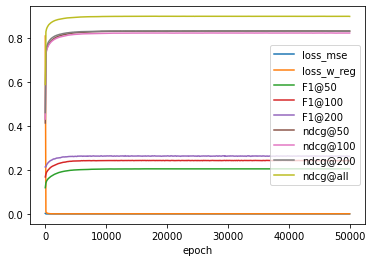

In [32]:
pd.set_option('display.max_rows', 500)
results_df = pd.DataFrame(results).set_index('epoch')
results_df.plot()
results_df

In [33]:
results_df['model'] = 'our-lasso'
final_results.append(results_df[select_columns].iloc[-1])

## Quality Check

In [34]:
# select doc_id and k
doc_id = 3
topk = 50

model

LR(
  (emb): Embedding(495, 3254)
)

In [35]:
import colored
from colored import stylize

word_list = dataset.vocab.itos

gt = [word_list[word_idx] for word_idx in np.argsort(weight_ans[doc_id])[::-1][:topk]]
pred = [word_list[word_idx] for word_idx in np.argsort(model.emb.cpu().weight.data[doc_id].numpy())[::-1][:topk]]

print('ground truth')
for word in gt:
    if word in pred:
        print(stylize(word, colored.bg("yellow")), end=' ')
    else:
        print(word, end=' ')

print()
print('\nprediction')
for word in pred:
    if word in gt:
        print(stylize(word, colored.bg("yellow")), end=' ')
    else:
        print(word, end=' ')


ground truth
blood liver mum agent drug column dose phase random 0 oral mug transplant vivo fungal trial prior mg tube nm fungi 104 64 protocol flow minor cold review 150 19 document 45 43 liquid beyond monitor nitrogen undergo insulin 74 2000 ice twice layer 2001 confer 39 magnesium regimen week 

prediction
blood liver mum agent drug dose column cancer vivo oral constant random cholesterol phase 0 last filter liquid review skin mg protocol specimen heart date regular trial eight 72 start transplant sex powder 45 tumor prior request via file 96 112 mug person twice 165 q 355 yeast leukemia cd4 

In [36]:
# raw document
dataset.documents[doc_id]

'Voriconazole Inhibition of the Metabolism of Tacrolimus in a Liver Transplant Recipient and in Human Liver Microsomes The purpose of this study was to assess the effect of voriconazole on the blood tacrolimus concentration in a liver transplant recipient and to examine the interaction between voriconazole and tacrolimus by using human liver microsomes. Two subjects were enrolled in the clinical study: one received voriconazole, and the other received a placebo. Tacrolimus metabolism was evaluated in human liver microsomes at various concentrations in the absence and presence of various concentrations of voriconazole. Coadministration of voriconazole and tacrolimus resulted in elevated (nearly 10-fold-higher) trough tacrolimus blood concentrations in the liver transplant patient. In the in vitro study, voriconazole at a concentration of 10.4 +- 4.3 mug/ml inhibited the metabolism of tacrolimus by 50%. Clinically relevant concentrations of voriconazole inhibited the metabolism of tacrol

In [37]:
results = {}
   
scores = np.array(model.emb.weight.data)[doc_id].reshape(1, -1)
true_relevance = train_loader.dataset.weight_ans[doc_id].reshape(1, -1)

results['ndcg@50'] = (ndcg_score(true_relevance, scores, k=50))
results['ndcg@100'] = (ndcg_score(true_relevance, scores, k=100))
results['ndcg@200'] = (ndcg_score(true_relevance, scores, k=200))
results['ndcg@all'] = (ndcg_score(true_relevance, scores, k=None))

print('NDCG top50', results['ndcg@50'])
print('NDCG top100', results['ndcg@100'])
print('NDCG top200', results['ndcg@200'])
print('NDCG ALL', results['ndcg@all'])


NDCG top50 0.9030230734063925
NDCG top100 0.9139658517098421
NDCG top200 0.918499022641884
NDCG ALL 0.9510508128448044


## Final results

In [38]:
final_results_df = pd.DataFrame(final_results).reset_index(drop=True)

experiment_dir = './records/dataset-{}-n_document-{}-wdist-{}-filtertopk-{}'.format(
                                        config['dataset'],
                                        config['n_document'],
                                        config["document_vector_agg_weight"],
                                        config["topk_word_freq_threshold"])
os.makedirs(experiment_dir, exist_ok=True)
                


In [39]:
final_results_df.to_csv(os.path.join(experiment_dir, 'result.csv'), index=False)

import json
with open(os.path.join(experiment_dir, 'config.json'), 'w') as json_file:
    json.dump(config, json_file)

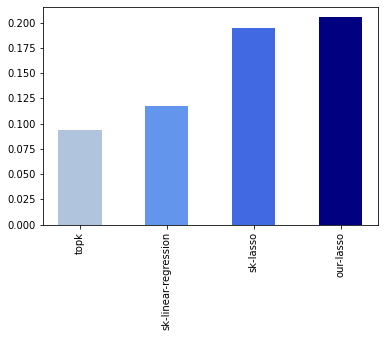

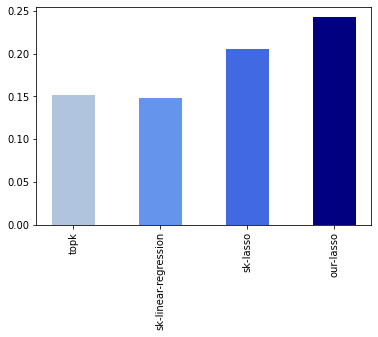

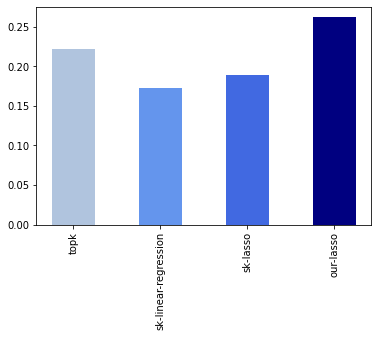

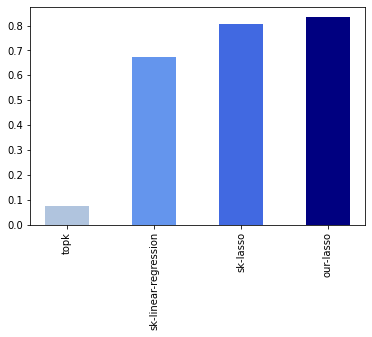

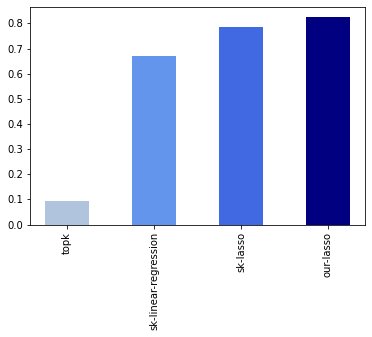

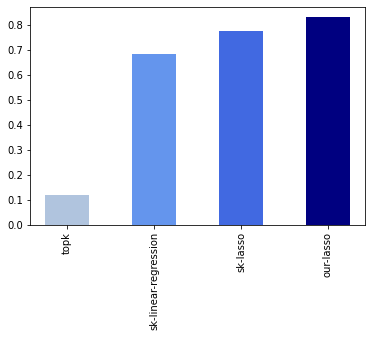

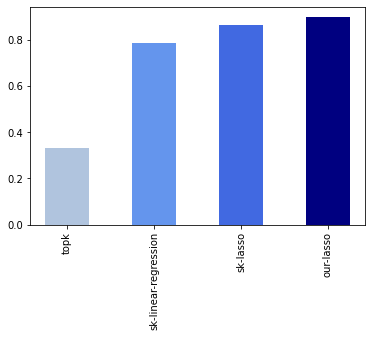

In [40]:
for feat in final_results_df.set_index('model').columns:
    plt.bar(final_results_df['model'],
            final_results_df[feat], 
            width=0.5, 
            bottom=None, 
            align='center', 
            color=['lightsteelblue', 
                   'cornflowerblue', 
                   'royalblue', 
                   'navy'])
    plt.xticks(rotation='vertical')
    plt.savefig(os.path.join(experiment_dir, '{}.png'.format(feat)))
    plt.show()

In [41]:
final_results_df

,model,F1@50,F1@100,F1@200,ndcg@50,ndcg@100,ndcg@200,ndcg@all
0,topk,0.093618,0.151708,0.222107,0.075633,0.092695,0.117092,0.333257
1,sk-linear-regression,0.117154,0.148277,0.172500,0.673415,0.671709,0.686655,0.788487
2,sk-lasso,0.194806,0.205829,0.188654,0.806047,0.787418,0.778638,0.864406
3,our-lasso,0.205174,0.242204,0.261944,0.832600,0.823519,0.831824,0.899289
